DL Assignment 2
(By: Shyam Kumar Sodankoor(19230735) and Harshith Shankar Tarikere Ravikumar(19230323))

In [0]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd

# Data Preprocessing. This function loads the review files, reads the sentence and returns it
# Source: https://machinelearningmastery.com/prepare-movie-review-data-sentiment-analysis/
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r',encoding="utf8")
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# Data Preprocessing. This function uses load_doc and reads sentences from each folder and returns a list of reviews 
# Source: https://machinelearningmastery.com/prepare-movie-review-data-sentiment-analysis/
def process_docs(directory):
	lines = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip files that do not have the right extension
		if not filename.endswith(".txt"):
			continue
		# create the full path of the file to open
		path = directory + '//' + filename
		# load and clean the doc
		line = load_doc(path)
		# add to list
		lines.append(line)
	return lines

# Read all the files and store them in lists 
train_file_neg = "aclImdb\train\neg"
train_negative_lines = process_docs(train_file_neg)
train_file_pos = "aclImdb\train\pos"
train_positive_lines = process_docs(train_file_pos)
test_file_neg = "aclImdb\test\neg"
test_negative_lines = process_docs(test_file_neg)
test_file_pos = "aclImdb\test\pos"
test_positive_lines = process_docs(test_file_pos)

# Create dataframes for each of the review lists
senti_df = pd.DataFrame(train_positive_lines)
senti_df.columns = ["Review"]
senti_df['Sentiment'] = 1
senti_df1 = pd.DataFrame(train_negative_lines)
senti_df1.columns = ["Review"]
senti_df1['Sentiment'] = 0
senti_df2 = pd.DataFrame(test_positive_lines)
senti_df2.columns = ["Review"]
senti_df2['Sentiment'] = 1
senti_df3 = pd.DataFrame(test_negative_lines)
senti_df3.columns = ["Review"]
senti_df3['Sentiment'] = 0

# Create a final dataframe containing all the reviews and their senitments
senti_df_final = pd.concat([senti_df,senti_df1,senti_df2,senti_df3],ignore_index=True)

In [0]:
# Sources Referred
# https://machinelearningmastery.com/prepare-movie-review-data-sentiment-analysis/
# https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
# https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
# https://keras.io/examples/imdb_lstm/

import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from __future__ import print_function

from nltk.corpus import stopwords
from string import punctuation
import re

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

# Preprocessing the sentences
# This function does the preprocessing of each sentence like removing html tags,
# stopwords and other unwanted stuff
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # split into tokens by white space
    tokens = sentence.split()
	  # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
	  # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
  	# filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
	  # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    sentence = ' '.join(tokens)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

# Preprocessing the reviews
X = []
sentences = senti_df_final['Review']
for sen in sentences:
    X.append(preprocess_text(sen))

y = np.array(senti_df_final['Sentiment'])

max_features = 5000
# cut texts after this number of words (among top max_features most common words)
maxlen = 500
batch_size = 128

print('Loading data...')

# Setting first 50% of the data as training data as given in the files
x_train = X[:24999]
y_train = y[:24999]
x_test = X[25000:]
y_test = y[25000:]

# Vectorizing the words using Tokenizer object
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 500

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
# Padding the input sequence with a maximum length of 500
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
# Building a sequential model
model = Sequential()
# Adding an embedding layer 
model.add(Embedding(max_features, 128))
# Adding an LSTM layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# Adding a dense layer with 256 nodes
model.add(Dense(256, activation='relu'))
# Adding a final sigmoid layer
model.add(Dense(1, activation='sigmoid'))

# Using binary-crossentropy loss function with Adam optimizer
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')

# Fitting the model using a batch size of 128 and 2 epochs
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, y_test))

# Calculating test score and accuracy of the model using the test data
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Loading data...
24999 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (24999, 500)
x_test shape: (25000, 500)
Build model...
Train...
Epoch 1/10
196/196 [==============================] - 645s 3s/step - loss: 0.4178 - accuracy: 0.8083 - val_loss: 0.3333 - val_accuracy: 0.8626
Epoch 2/10
196/196 [==============================] - 656s 3s/step - loss: 0.2572 - accuracy: 0.8988 - val_loss: 0.3131 - val_accuracy: 0.8680
Epoch 3/10
196/196 [==============================] - 647s 3s/step - loss: 0.2061 - accuracy: 0.9216 - val_loss: 0.3508 - val_accuracy: 0.8660
Epoch 4/10
196/196 [==============================] - 634s 3s/step - loss: 0.1720 - accuracy: 0.9342 - val_loss: 0.3603 - val_accuracy: 0.8588
Epoch 5/10
196/196 [==============================] - 638s 3s/step - loss: 0.1449 - accuracy: 0.9462 - val_loss: 0.3948 - val_accuracy: 0.85

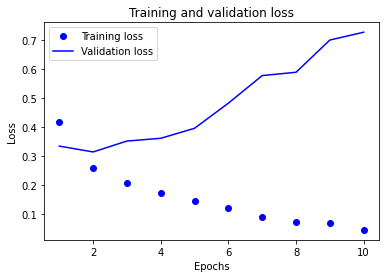

In [0]:
# Sources Referred
# https://www.kaggle.com/drscarlat/imdb-sentiment-analysis-keras-and-tensorflow

import matplotlib.pyplot as plt
plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Naive Bayes

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# Source : https://medium.com/@krsatyam1996/imdb-movie-review-polarity-using-naive-bayes-classifier-9f92c13efa2d

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score

X = []
sentences = senti_df_final['Review']
for sen in sentences:
    X.append(preprocess_text(sen))

y = np.array(senti_df_final['Sentiment'])

max_features = 5000
# cut texts after this number of words (among top max_features most common words)
maxlen = 500
batch_size = 128

print('Loading data...')


X_train = X[:24999]
y_train = y[:24999]
X_test = X[25000:]
y_test = y[25000:]


vectorizer = CountVectorizer(max_features=50000)
vectorizer.fit(X_train+X_test)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

nb = MultinomialNB(alpha=6)
nb.fit(X_train, y_train)

acc = accuracy_score(y_test,nb.predict(X_test),normalize=True) * float(100)
print("Accuracy =", acc)

Loading data...
Accuracy = 83.44
